Project to migrate my original code for predicting the sentimment of Yelp reviews from SKlearn to PySpark.

## 1. Configure Spark

In [152]:
# import libraries for setting up spark and sql contexts
from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrameReader, SQLContext, DataFrameWriter

# import libraries for defining custom functions - udf indicates user defined function, type defines the type the function will return
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import os


# define to postgres jdbc driver path as environment variable
sparkClassPath = os.getenv('SPARK_CLASSPATH', 
                           '/Users/user/Downloads/postgresql-42.2.14.jar')

In [153]:
# define configuration settings for Spark
conf = SparkConf()
conf.setAppName('application')
conf.set('spark.jars', f'file:{sparkClassPath}')
conf.set('spark.executor.extraClassPath', sparkClassPath)
conf.set('spark.driver.extraClassPath', sparkClassPath)

# define spark context - interface between client (notebook) and cluster manager
sc = SparkContext(conf=conf)
# define sql context - entry point for spark sql functionalkty - register dataframe as tables, which you can execute SQL on
sqlContext = SQLContext(sc)

# define postgres connection parameters
url = 'postgresql://localhost:5432/user'
properties = {'user': 'user', 'password': ''}

## 2. Sample Yelp review data

In [154]:
# define user defined function for create target column
set_target_values = udf(lambda x: (x > 3)*1, IntegerType())

In [155]:
# define sampling query
def get_sample(sample_size=100):
    query = """
            with reviews_1 as (
            select review_id, stars, text
            from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75) 
            where stars = 1
            limit """ + str(sample_size) + """
            )
            , reviews_2 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 2
                limit """ + str(sample_size) + """
            )
            , reviews_4 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 4
                limit """ + str(sample_size) + """
            )
            , reviews_5 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 5
                limit """ + str(sample_size) + """
            )

            select *
            from reviews_1
            union
            select *
            from reviews_2
            union
            select *
            from reviews_4
            union
            select *
            from reviews_5 
            """
    
    # read data from postgres into a dataframe
    df = DataFrameReader(sqlContext).jdbc(url=f'jdbc:{url}', 
                                      table=f'({query}) as sample', 
                                      properties=properties)
    
    df = df.withColumn('target', set_target_values(df.stars))
    
    return df

In [156]:
yelp = get_sample(5000) 

In [157]:
yelp.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [158]:
yelp.show(5)

+--------------------+-----+--------------------+------+
|           review_id|stars|                text|target|
+--------------------+-----+--------------------+------+
|Ndx0c6FUQNxwMd-2U...|    5|my favorite tacos...|     1|
|2BGTuL2tud2Dousa7...|    4|we got king wah t...|     1|
|tWgOjQCkwN5glOgWY...|    2|someone else post...|     0|
|EeUNVG3FQS8kz9y-T...|    2|when in vegas do ...|     0|
|OTN-huMbwaHkqXp4J...|    1|in my opinion def...|     0|
+--------------------+-----+--------------------+------+
only showing top 5 rows



In [159]:
yelp.describe().show()

+-------+--------------------+-----------------+-----------------------------------+----------------+
|summary|           review_id|            stars|                               text|          target|
+-------+--------------------+-----------------+-----------------------------------+----------------+
|  count|               20000|            20000|                              20000|           20000|
|   mean|                null|              3.0|                               null|             0.5|
| stddev|                null|1.581178360037318|                               null|0.50001250046877|
|    min|--7955vOboy-p8aTe...|                1|                already? not sur...|               0|
|    max|zzaEtm6fgZIcvYQQ9...|                5|味道不好，每小碗米饭$2，刷卡另加...|               1|
+-------+--------------------+-----------------+-----------------------------------+----------------+



In [160]:
yelp.select('stars', 'target').show(5)

+-----+------+
|stars|target|
+-----+------+
|    1|     0|
|    4|     1|
|    1|     0|
|    2|     0|
|    2|     0|
+-----+------+
only showing top 5 rows



In [161]:
yelp.groupby('stars').count().sort('stars').show()

+-----+-----+
|stars|count|
+-----+-----+
|    1| 5000|
|    2| 5000|
|    4| 5000|
|    5| 5000|
+-----+-----+



In [162]:
# create temp view which SQL Context can use to run SQL queries on
yelp.createOrReplaceTempView('sample')

In [163]:
sqlContext.sql('select avg(stars) from sample').show()

+----------+
|avg(stars)|
+----------+
|       3.0|
+----------+



## 3a. Pre-process data for modelling - Manual steps

In [164]:
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [165]:
# set review test to lowercase
yelp = yelp.withColumn('text', lower(yelp.text))

In [166]:
yelp.select('text').show(10, truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|honestly this is the best korean bbq i've ever ...|
|spring garden is just the best they have great ...|
|the chimichangas were alright, not bad. guacamo...|
|super nice service. food is ok like any other k...|
|good priced rooms. very ordinary. go down to th...|
|today i ordered the pene rustica dish, it's oka...|
|the service was fine but most of the food is gr...|
|came here for a late night dinner since our oth...|
|2nd visit - food & service were great. we made ...|
|one of my favorite tea houses! the food is very...|
+--------------------------------------------------+
only showing top 10 rows



In [167]:
# remove punctuation
yelp = yelp.withColumn('text', regexp_replace(yelp.text, '[^\w\s\d]+', ''))

In [168]:
yelp.select('text').show(10, truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|quality of food has went downhill and not to me...|
|this location does not understand the concept o...|
|visited a few times now and the food is very co...|
|love it fresh and done right the food doesnt sw...|
|ebc is the best dayclub in vegas hands down  ev...|
|very disappointing i wasnt expecting much to be...|
|3 times in a row without fortune cookies and th...|
|i have been to other einstein bro before but th...|
|ive been checking out a new coffee shop almost ...|
|i have been to way too many chipotle restaurant...|
+--------------------------------------------------+
only showing top 10 rows



In [169]:
# tokenize review text
tokenizer = Tokenizer(inputCol='text', outputCol='word_tokens')

In [170]:
yelp_word_tokens = tokenizer.transform(yelp).select('review_id', 'stars', 'target', 'word_tokens')

In [171]:
yelp_word_tokens.show(5)

+--------------------+-----+------+--------------------+
|           review_id|stars|target|         word_tokens|
+--------------------+-----+------+--------------------+
|gNePHbiB5iMqr85sB...|    2|     0|[taco, guild, has...|
|pzuFOYimnHO9_7dHo...|    5|     1|[man, that, sumo,...|
|uz8xllzD9lkmUj7_x...|    4|     1|[we, ordered, pot...|
|lnyMoX0VNFlHrozyH...|    1|     0|[was, all, excite...|
|yVXXc__c_z8h1lCCY...|    2|     0|[the, food, was, ...|
+--------------------+-----+------+--------------------+
only showing top 5 rows



In [172]:
# remove stop words
st_remover = StopWordsRemover(inputCol='word_tokens', outputCol='words_clean', stopWords=stopwords.words('english'))

In [173]:
yelp_words_clean = st_remover.transform(yelp_word_tokens).select('review_id', 'stars', 'target', 'words_clean')

In [174]:
yelp_words_clean.show(5)

+--------------------+-----+------+--------------------+
|           review_id|stars|target|         words_clean|
+--------------------+-----+------+--------------------+
|LD_wVG4iUzpFdkrT_...|    4|     1|[fair, ive, homem...|
|0yExuN4BYNDoXgqjR...|    2|     0|[overall, underwh...|
|GSvkQkoxySczfJDDL...|    2|     0|[, food, okay, ho...|
|uiWKwBFoBqlNP-xJ_...|    5|     1|[loved, loved, lo...|
|yRc3umgF-pHcSzpfy...|    5|     1|[brunch, twice, l...|
+--------------------+-----+------+--------------------+
only showing top 5 rows



In [175]:
# stem words
stemmer = PorterStemmer()
stemmer_udf = udf(lambda tokens: [stemmer.stem(w) for w in tokens], ArrayType(StringType()))

In [176]:
yelp_stemmed = yelp_words_clean.withColumn('words_clean', stemmer_udf(yelp_words_clean.words_clean))

In [177]:
yelp_stemmed.select('words_clean').show(10, truncate=50)

+--------------------------------------------------+
|                                       words_clean|
+--------------------------------------------------+
|[cupcak, good, hit, miss, twice, ive, first, ti...|
|[realli, realli, realli, like, restaur, cant, b...|
|[came, dinner, week, ago, price, 35, wasnt, bad...|
|[im, one, ever, write, neg, review, unless, sit...|
|[16, fail, health, inspect, 7, sever, ill, peop...|
|[manag, short, blond, hair, need, fire, wait, o...|
|[come, 8, year, last, night, first, visit, , th...|
|[sometim, skip, line, starbuck, pop, panera, co...|
|[could, would, give, 0, star, got, coupon, door...|
|[plaza, casino, remind, senior, citizen, home, ...|
+--------------------------------------------------+
only showing top 10 rows



In [178]:
# fitler short words
remove_empty_udf = udf(lambda tokens: [w for w in tokens if len(w) > 2], ArrayType(StringType()))

In [179]:
yelp_stemmed = yelp_stemmed.withColumn('words_clean', remove_empty_udf(yelp_stemmed.words_clean))

In [180]:
yelp_stemmed.select('words_clean').show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                         words_clean|
+----------------------------------------------------------------------------------------------------+
|[first, nativ, montreal, live, year, plateau, outremont, default, make, expert, come, smoke, meat...|
|[last, time, went, island, pasadena, think, andbut, rememb, bad, date, give, second, chanc, islan...|
|                                   [place, amaz, food, tri, sever, thing, favorit, steak, taco, yum]|
|[hereunless, enjoy, eat, roach, infest, restaur, lunch, wait, seat, wit, huge, cockroach, stroll,...|
|[came, angri, crab, shack, dinner, famili, highli, disappoint, waitress, shelbi, seem, like, tri,...|
|            [nice, neighborhood, place, kid, love, goat, chees, stuf, date, wrap, prosciutto, yummi]|
|[peg, glorifi, ham, egg, henderson, vega, lot, great, breakfast, spot, c

In [181]:
from pyspark.ml.feature import NGram

In [182]:
# create ngrams = 2 col
ngrams = NGram(n=2, inputCol='words_clean', outputCol='ngrams_2')
yelp_ngrams = ngrams.transform(yelp_stemmed)

In [183]:
yelp_ngrams.show(5, truncate=50)

+----------------------+-----+------+--------------------------------------------------+--------------------------------------------------+
|             review_id|stars|target|                                       words_clean|                                          ngrams_2|
+----------------------+-----+------+--------------------------------------------------+--------------------------------------------------+
|EhwNarjig7WFKxMonzRD_w|    4|     1|[happen, see, restaur, pass, decid, pleasantli,...|[happen see, see restaur, restaur pass, pass de...|
|62mcOkcaRmNHAOWGAPTBqg|    5|     1|[amaz, food, fantast, pianist, excel, servic, b...|[amaz food, food fantast, fantast pianist, pian...|
|2vI4oC6gQQEMt8yMZHWyWA|    1|     0|[one, worst, dine, experi, food, came, cold, ha...|[one worst, worst dine, dine experi, experi foo...|
|8ozR5Ydw5wazU2D5xUtY-g|    2|     0|[went, lunch, friend, today, white, sangria, ho...|[went lunch, lunch friend, friend today, today ...|
|2xsWWuJJvBq9SwFABVx

In [184]:
# merge feature columns
merge_words_udf = udf(lambda col1, col2: col1 + col2, ArrayType(StringType()))

In [185]:
yelp_merged = yelp_ngrams.withColumn('features', merge_words_udf(yelp_ngrams.words_clean, yelp_ngrams.ngrams_2)).select('target', 'features')

In [186]:
# Create CountVectorizer
cv = CountVectorizer(minDF=5, vocabSize=100000, inputCol='features', outputCol='vectors')

In [187]:
cv_model = cv.fit(yelp_merged)
yelp_cv = cv_model.transform(yelp_merged)

In [188]:
yelp_cv.show(5, truncate=100)

+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|target|                                                                                            features|                                                                                             vectors|
+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|     1|[place, much, fun, staff, extrem, great, help, great, person, qualiti, meat, unriv, kobe, salmon,...|(39077,[2,5,8,22,24,29,48,51,52,56,101,131,139,163,175,194,197,204,211,214,319,331,336,340,341,35...|
|     0|[charg, peopl, remain, food, without, let, know, first, com, charg peopl, peopl remain, remain fo...|(39077,[0,39,47,59,205,246,257,1163,2161,12220,

In [189]:
# total number of words in the vocabulary
len(cv_model.vocabulary)

39077

In [190]:
# list of words in the vocabulary
sorted(cv_model.vocabulary)[:10]

['050',
 '100',
 '100 back',
 '100 bill',
 '100 challeng',
 '100 degre',
 '100 time',
 '100 worth',
 '1000',
 '1000 island']

In [191]:
# fit IDF
idf = IDF(inputCol='vectors', outputCol='vectors_idf')

In [192]:
yelp_idf = idf.fit(yelp_cv).transform(yelp_cv.select('target', 'vectors')).select('target', 'vectors_idf')

In [193]:
yelp_idf.show(5, truncate=100)

+------+----------------------------------------------------------------------------------------------------+
|target|                                                                                         vectors_idf|
+------+----------------------------------------------------------------------------------------------------+
|     0|(39077,[1,5,10,14,21,22,26,27,28,29,30,33,47,52,57,59,63,69,74,75,78,80,81,97,113,115,126,177,196...|
|     0|(39077,[1,2,3,4,5,7,8,9,13,15,22,24,26,29,30,35,37,39,44,46,49,55,58,62,66,69,73,74,75,78,82,84,8...|
|     1|(39077,[4,10,15,38,39,68,98,108,133,156,169,191,247,249,397,499,589,667,730,757,997,1308,1404,168...|
|     1|(39077,[0,3,7,9,13,16,20,26,31,41,45,50,57,70,80,88,134,153,204,209,234,280,283,339,341,381,392,3...|
|     1|(39077,[0,3,6,12,37,41,51,60,80,86,99,131,209,220,224,230,459,467,472,514,763,875,1334,2070,2117,...|
+------+----------------------------------------------------------------------------------------------------+
only showi

## 3b. Pre-process data for modelling - Pipeline

I could not easily create a pipeline for the above steps (3a.) as all the pre-processing stages require fit/transnform steps. I have two options for creating a pipeline:

- write a class for doing pre-processing for those steps which lack a tranform method
- re-write my code to allow for using methods which support .transform()

I will leave this for now and move to model creation.

## 4. Model Creation

In [194]:
import numpy as np
import pandas as pd
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from time import time
import statistics

In [195]:
# split data into training and test sets
data_train, data_test = yelp_idf.randomSplit([0.8, 0.2], seed=1)

In [196]:
# check sampling weights for target in training set
data_train.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 8012|
|     0| 8004|
+------+-----+



In [197]:
# check sampling weights for target in testing set
data_test.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1988|
|     0| 1996|
+------+-----+



In [198]:
# setup models and parameters for gridsearching
nb = NaiveBayes(featuresCol='vectors_idf',labelCol='target')
lr = LogisticRegression(featuresCol='vectors_idf',labelCol='target')
svc = LinearSVC(featuresCol='vectors_idf',labelCol='target')


models = {
    'Naive Bayes': (nb, 
                     ParamGridBuilder() \
                     .addGrid(nb.modelType, ['multinomial']) \
                     .build()),
    'Linear SVC': (svc, 
                      ParamGridBuilder() \
                      .addGrid(svc.regParam, np.linspace(8, 12, 5)) \
                      .build()),  
    'Logistic Regression': (lr, 
                            ParamGridBuilder() \
                            .addGrid(lr.regParam, np.linspace(6, 11, 5)) \
                            .build())    
}

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='target', metricName='areaUnderROC')

In [108]:
# Gridsearch models to find best parameters - print out results for test set based on best parameters
for key, value in models.items():
    print('Model: ', key)
    crossval = CrossValidator(estimator=value[0], estimatorParamMaps=value[1], evaluator=evaluator, numFolds=5)
    
    t0 = time()
    model_fit = crossval.fit(data_train)
    train_time = time() - t0
    print(("Train time: %0.3fs" % train_time))
    
    # find the best model parameters
    java_model = model_fit.bestModel._java_obj
    print('Best model parameters:', {param.name: java_model.getOrDefault(java_model.getParam(param.name)) for param in value[1][0]})
    
    # get average CV score for chosen metric
    print('Avg. CV Area Under ROC: ', np.round(statistics.mean(model_fit.avgMetrics),3))
    
    # get predictions for test set
    pred_test = model_fit.transform(data_test)
    test_target = [int(row['target']) for row in pred_test.collect()]
    test_pred = [int(row['prediction']) for row in pred_test.collect()]

    print('Test Area Under ROC: ', np.round(evaluator.evaluate(pred_test),3))
    print("Test accuracy : ", np.round(accuracy_score(test_target, test_pred),3))

    print('\nconfusion matrix: ')
    print(confusion_matrix(test_target, test_pred))
    print('\n')
    print(classification_report(test_target, test_pred))
    print('-' * 60)

Model:  Naive Bayes
Train time: 588.856s
Best model parameters: {'modelType': 'multinomial'}
Avg. CV Area Under ROC:  0.897
Test Area Under ROC:  0.904
Test accuracy :  0.899

confusion matrix: 
[[1750  246]
 [ 157 1831]]


              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1996
           1       0.88      0.92      0.90      1988

    accuracy                           0.90      3984
   macro avg       0.90      0.90      0.90      3984
weighted avg       0.90      0.90      0.90      3984

------------------------------------------------------------
Model:  Linear SVC
Train time: 1102.137s
Best model parameters: {'regParam': 8.0}
Avg. CV Area Under ROC:  0.9
Test Area Under ROC:  0.921
Test accuracy :  0.913

confusion matrix: 
[[1748  248]
 [  97 1891]]


              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1996
           1       0.88      0.95      0.92      1988

    accuracy 

In [199]:
# assign optimal LR parameters
lr.setRegParam = 6.0

model = lr.fit(data_test)

In [200]:
model_summary = model.summary

In [201]:
model_summary.areaUnderROC

0.9307783071172524

In [202]:
model_summary.predictions.select('target', 'probability', 'prediction').show(10, truncate=False)

+------+-----------------------------------------+----------+
|target|probability                              |prediction|
+------+-----------------------------------------+----------+
|0.0   |[1.0,6.715354157768528E-33]              |0.0       |
|0.0   |[1.0,5.576751010898905E-23]              |0.0       |
|0.0   |[0.9999643391719879,3.566082801203105E-5]|0.0       |
|0.0   |[1.0,5.33079225229859E-31]               |0.0       |
|0.0   |[1.0,1.0207591076532884E-17]             |0.0       |
|0.0   |[0.9999999999999916,8.46127963316544E-15]|0.0       |
|0.0   |[1.0,1.295275115199729E-45]              |0.0       |
|0.0   |[1.0,1.2535116971189236E-22]             |0.0       |
|0.0   |[1.0,1.4184568886533643E-59]             |0.0       |
|0.0   |[1.0,7.810056803462182E-34]              |0.0       |
+------+-----------------------------------------+----------+
only showing top 10 rows



In [203]:
import matplotlib.pyplot as plt

AttributeError: 'NoneType' object has no attribute 'setCallSite'

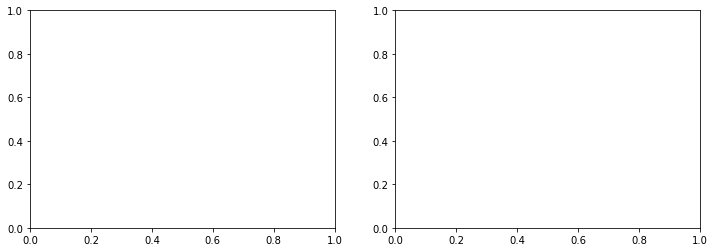

In [204]:
# create AUC & PR curves for chosen model
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
model_summary.roc.toPandas().plot(x='FPR', y='TPR', ax=ax[0])
model_summary.pr.toPandas().plot(x='recall', y='precision', ax=ax[1])
plt.show()

In [151]:
# stop spark cluster
sc.stop()